In [382]:
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, classification_report, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score

np.set_printoptions(suppress=True) 

#### Import dataset

In [468]:
pima = pd.read_csv("pima-indians-diabetes.csv", header=None)
X = pima.iloc[:,:8].to_numpy()
Y = pima.iloc[:,8].to_numpy()

### Part 1 & 2: Non-imbalanced Data

##### Create train & test data

In [469]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=0)

##### Logistic Regression 

In [470]:
def logistic_reg(x_train, y_train, x_test, y_test):
    lr = LogisticRegression(solver='lbfgs', max_iter=10000)
    lr.fit(x_train, y_train)  
    y_pred_train=lr.predict(x_train)
    y_pred_test=lr.predict(x_test)
    prob_test = lr.predict_proba(x_test)
    prob_train = lr.predict_proba(x_train)
    return y_pred_train, prob_train, y_pred_test, prob_test  

In [471]:
Y_pred_train, prob_train, Y_pred_test, prob_test = logistic_reg(X_train, Y_train, X_test, Y_test)

##### Accuracy, Log loss & RMSE

In [472]:
def evaluation_metrics_1(y_train, y_pred_train, prob_train, y_test, y_pred_test, prob_test):
    print('Log Loss (train): ', log_loss(y_train, prob_train))
    print('Log Loss (test): ', log_loss(y_test, prob_test),'\n')
    
    print('Accuracy score (train): ', accuracy_score(y_train, y_pred_train))
    print('Accuracy score (test): ', accuracy_score(y_test, y_pred_test),'\n')
    
    print('RMSE (train): ', mean_squared_error(y_train, y_pred_train, squared=False))
    print('RMSE (test): ', mean_squared_error(y_test, y_pred_test, squared=False),'\n')

In [473]:
evaluation_metrics_1(Y_train, Y_pred_train, prob_train, Y_test, Y_pred_test, prob_test)

Log Loss (train):  0.4844436666962613
Log Loss (test):  0.45705953849047604 

Accuracy score (train):  0.7608695652173914
Accuracy score (test):  0.788961038961039 

RMSE (train):  0.48900964692182575
RMSE (test):  0.45938977028114264 



##### AUROC, Precision-recall & F1 score

In [474]:
def evaluation_metrics_2(y, y_pred, prob):
    #keep probabilities for positive outcome only
    pos_prob = prob[:, 1] 
    auc = roc_auc_score(y, pos_prob)
    fpr, tpr, _ = roc_curve(y, pos_prob)
    
    print('ROC AUC score: ', auc)
    plt.plot(fpr, tpr, marker='.', color='darkorange', label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    plt.clf()
    
    precision, recall, _ = precision_recall_curve(y, pos_prob)
    f1 = f1_score(y, y_pred)
    
    print('F1 score: ', f1)
    plt.plot(recall, precision, marker='.', color='darkorange', label='Logistic')
    plt.plot([0, 1], [0, 0], color='navy', lw=2, linestyle='--', label='No skill')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-recall curve')
    plt.legend()
    plt.show()
    plt.clf()

ROC AUC score:  0.8455600284158181


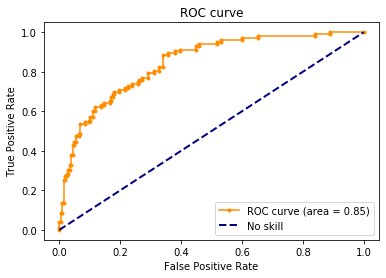

F1 score:  0.6285714285714286


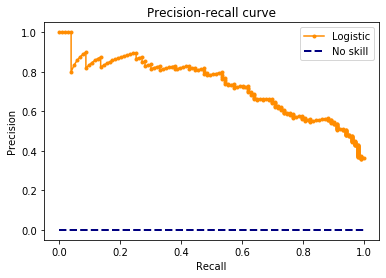

<Figure size 432x288 with 0 Axes>

In [475]:
evaluation_metrics_2(Y_test, Y_pred_test, prob_test)

### Part 3: Imbalanced Data

##### Make data class-imbalanced 

In [476]:
num_zeros = (Y == 0).sum() #500
num_ones = (Y == 1).sum() #268

#Make data 90% for 0 and 10% for 1 i.e. select all 500 0s and 50 1s
index_0_all = np.where(Y == 0)
index_1_all = np.where(Y == 1)
index_1_all_arr = np.array(index_1_all).flatten()
index_1_10 = np.random.choice(index_1_all_arr, 10)

Y0 = Y[index_0_all]
X0 = X[index_0_all]
Y1 = Y[index_1_10]
X1 = X[index_1_10]

Y_imb = np.hstack((Y0, Y1))
X_imb = np.vstack((X0, X1))

##### Create train & test data

In [477]:
X_train, X_test, Y_train, Y_test = train_test_split(X_imb,Y_imb,test_size=0.4,random_state=0)

##### Logistc Regression 

In [478]:
Y_pred_train, prob_train, Y_pred_test, prob_test = logistic_reg(X_train, Y_train, X_test, Y_test)

##### Accuracy, Log loss & RMSE

In [479]:
evaluation_metrics_1(Y_train, Y_pred_train, prob_train, Y_test, Y_pred_test, prob_test)

Log Loss (train):  0.031168205376183054
Log Loss (test):  0.4384077697755454 

Accuracy score (train):  0.9836601307189542
Accuracy score (test):  0.9656862745098039 

RMSE (train):  0.1278274981412284
RMSE (test):  0.1852396434087371 



##### AUROC, Precision-recall & F1 score

ROC AUC score:  0.4753768844221105


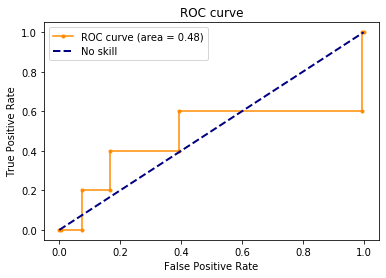

F1 score:  0.0


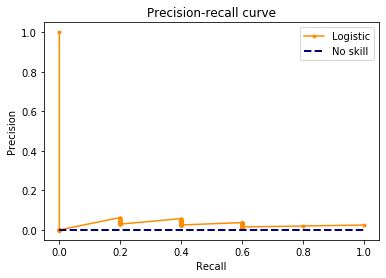

<Figure size 432x288 with 0 Axes>

In [480]:
evaluation_metrics_2(Y_test, Y_pred_test, prob_test)

### Part 4: 10-fold Cross Validation 

In [451]:
def nfold_cross_validation(x, y, n):
    lr = LogisticRegression(solver='lbfgs', max_iter=10000)
    cv_results = cross_validate(lr, x, y, cv=n, scoring=('accuracy','neg_log_loss','roc_auc'))
    print('CV Test score results:\n')
    print('Accuracy:', cv_results['test_accuracy'])
    print('Accuracy (mean):', cv_results['test_accuracy'].mean(),'\n')
    print('Log loss:', -cv_results['test_neg_log_loss'])
    print('Log loss (mean):', -cv_results['test_neg_log_loss'].mean(),'\n')
    print('ROC AUC:', cv_results['test_roc_auc'])
    print('ROC AUC (mean):', cv_results['test_roc_auc'].mean(),'\n')

In [452]:
nfold_cross_validation(X, Y, 10)

CV Test score results:

Accuracy: [0.72727273 0.77922078 0.80519481 0.71428571 0.75324675 0.76623377
 0.80519481 0.80519481 0.75       0.82894737]
Accuracy (mean): 0.7734791524265209 

Log loss: [0.54305584 0.47366595 0.46980849 0.54481032 0.51093967 0.44896307
 0.50891263 0.383774   0.48733723 0.46886116]
Log loss (mean): 0.48401283510351006 

ROC AUC: [0.78518519 0.82444444 0.83703704 0.77333333 0.81185185 0.84592593
 0.81851852 0.91481481 0.85076923 0.83230769]
ROC AUC (mean): 0.8294188034188034 



### Part 5 : Ridge & Lasso Regression

In [481]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=0)

##### Lasso Regression (L1 penalty)

In [482]:
lasso = linear_model.LassoCV()
lasso.fit(X_train, Y_train)

prob_train=lasso.predict(X_train)
prob_test=lasso.predict(X_test)

Y_pred_train = np.where(prob_train>0.5, 1, 0)
Y_pred_test = np.where(prob_test>0.5, 1, 0)

In [483]:
print('Log Loss (train): ', log_loss(Y_train, prob_train))
print('Log Loss (test): ', log_loss(Y_test, prob_test),'\n')
    
print('Accuracy score (train): ', accuracy_score(Y_train, Y_pred_train))
print('Accuracy score (test): ', accuracy_score(Y_test, Y_pred_test),'\n')

print('AUC score (train): ', roc_auc_score(Y_train, prob_train))
print('AUC score (test): ', roc_auc_score(Y_test, prob_test),'\n')

print('F1 score (train): ', f1_score(Y_train, Y_pred_train))
print('F1 score (test): ', f1_score(Y_test, Y_pred_test))

Log Loss (train):  0.6266293387126821
Log Loss (test):  0.4684058362283855 

Accuracy score (train):  0.7608695652173914
Accuracy score (test):  0.7824675324675324 

AUC score (train):  0.8270364663585001
AUC score (test):  0.8325834714657827 

F1 score (train):  0.6283783783783783
F1 score (test):  0.6127167630057803


##### Ridge Regression (L2 penalty)

In [484]:
ridge = linear_model.RidgeCV()
ridge.fit(X_train, Y_train)

prob_train=ridge.predict(X_train)
prob_test=ridge.predict(X_test)

Y_pred_train = np.where(prob_train>0.5, 1, 0)
Y_pred_test = np.where(prob_test>0.5, 1, 0)

In [485]:
print('Log Loss (train): ', log_loss(Y_train, prob_train))
print('Log Loss (test): ', log_loss(Y_test, prob_test),'\n')
    
print('Accuracy score (train): ', accuracy_score(Y_train, Y_pred_train))
print('Accuracy score (test): ', accuracy_score(Y_test, Y_pred_test),'\n')

print('AUC score (train): ', roc_auc_score(Y_train, prob_train))
print('AUC score (test): ', roc_auc_score(Y_test, prob_test),'\n')

print('F1 score (train): ', f1_score(Y_train, Y_pred_train))
print('F1 score (test): ', f1_score(Y_test, Y_pred_test))

Log Loss (train):  0.625713430990025
Log Loss (test):  0.46241654701777885 

Accuracy score (train):  0.7565217391304347
Accuracy score (test):  0.788961038961039 

AUC score (train):  0.8323985618900873
AUC score (test):  0.8445654747809614 

F1 score (train):  0.6241610738255033
F1 score (test):  0.6285714285714286
